# LDA主题模型

LDA（Latent Dirichlet Allocation）是一种文档主题生成模型，也称为一个三层贝叶斯概率模型，包含词、主题和文档三层结构。所谓生成模型，就是说，我们认为一篇文章的每个词都是通过“以一定概率选择了某个主题，并从这个主题中以一定概率选择某个词语”这样一个过程得到。文档到主题服从多项式分布，主题到词服从多项式分布。
LDA是一种非监督机器学习技术，可以用来识别大规模文档集（document collection）或语料库（corpus）中潜藏的主题信息。它采用了词袋（bag of words）的方法，这种方法将每一篇文档视为一个词频向量，从而将文本信息转化为了易于建模的数字信息。但是词袋方法没有考虑词与词之间的顺序，这简化了问题的复杂性，同时也为模型的改进提供了契机。每一篇文档代表了一些主题所构成的一个概率分布，而每一个主题又代表了很多单词所构成的一个概率分布。

In [24]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim.models import LdaModel
import pandas as pd
from gensim.corpora import Dictionary
from gensim import corpora, models
import csv

## 加载数据

In [25]:
df = pd.read_csv('热辣滚烫好评影评.csv', index_col = 0) #导入文件

In [26]:
df.head()

,Name,Rate,Vote,Time,Comment,Location
ID,,,,,,
['4085785724'],['吴吴'],['4'],['43954'],['2024-02-10 15:54:19'],['她拍这部片子的目的根本不是说她瘦了这个事，是告诉你，无论你这个人活的有多烂、多失败、多差...,['湖北']
['4087285023'],['aiaiaixiahe'],['4'],['20586'],['2024-02-11 17:22:12'],['心疼贾玲，太强了。最有意思的是，影院一个男的看完出来说，“这种我一个月就练出来了”。太经...,['浙江']
['4086125600'],['Donuts🕳️'],['4'],['14065'],['2024-02-10 20:16:54'],['支持女的上桌，大上特上，大赚特赚，气死破防的人'],['贵州']
['4076452698'],['真珠'],['5'],['14901'],['2024-02-10 11:22:46'],['看完想大喊：姐！'],['安徽']
['4087374348'],['张春[阿卡纳]'],['5'],['4523'],['2024-02-11 18:37:56'],['一个女孩在关系里受尽屈辱历尽心死后，选择以训练自己身体的方式，独自前行，只拥抱了自己的对...,['福建']


In [27]:
df[['Comment']]= df[['Comment']].values.astype(str)

In [28]:
df['text_length'] = df["Comment"].apply(lambda x:len(x))
df = df[df['text_length']>5]   #删除评论字段小于5的评论

In [29]:
df.head()

,Name,Rate,Vote,Time,Comment,Location,text_length
ID,,,,,,,
['4085785724'],['吴吴'],['4'],['43954'],['2024-02-10 15:54:19'],['她拍这部片子的目的根本不是说她瘦了这个事，是告诉你，无论你这个人活的有多烂、多失败、多差...,['湖北'],97
['4087285023'],['aiaiaixiahe'],['4'],['20586'],['2024-02-11 17:22:12'],['心疼贾玲，太强了。最有意思的是，影院一个男的看完出来说，“这种我一个月就练出来了”。太经...,['浙江'],55
['4086125600'],['Donuts🕳️'],['4'],['14065'],['2024-02-10 20:16:54'],['支持女的上桌，大上特上，大赚特赚，气死破防的人'],['贵州'],27
['4076452698'],['真珠'],['5'],['14901'],['2024-02-10 11:22:46'],['看完想大喊：姐！'],['安徽'],12
['4087374348'],['张春[阿卡纳]'],['5'],['4523'],['2024-02-11 18:37:56'],['一个女孩在关系里受尽屈辱历尽心死后，选择以训练自己身体的方式，独自前行，只拥抱了自己的对...,['福建'],146


## 语料预处理

### 剔除符号与数字

In [30]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['Comment'][0]
remove_nums(test)[:100]

C:\Users\123\AppData\Local\Temp\ipykernel_86948\1222902338.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test = df['Comment'][0]


'她拍这部片子的目的根本不是说她瘦了这个事是告诉你无论你这个人活的有多烂多失败多差劲只要你找到一件事哪怕只是很小的一件事一直做专注做拼了命地做下去你会赢的哪怕就一次'

### 文本清理——停用词

In [31]:
#导入停用词
def stopwordslist():
    stopwords = [line.strip() for line in open('stop_word.txt',encoding='UTF-8').readlines()]
    return stopwords

In [32]:
#分词
def clean_text(text):
    sentence_depart = jieba.cut(text.strip()) 
    stopwords = stopwordslist()
    outstr = ''
    for word in sentence_depart:
        if word not in stopwords:
            if word != '/t':
                outstr += word
                outstr += " "
    return outstr

In [33]:
test = df['Comment'][0]
clean_text(test)

C:\Users\123\AppData\Local\Temp\ipykernel_86948\709382311.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test = df['Comment'][0]


'拍 这部 片子 目的 说 瘦 事 告诉 人活 多烂 失败 差劲 找到 一件 事 很小 一件 事 做 专注 做 拼了命 做 赢 '

In [34]:
df['Comment分词'] = df['Comment'].apply(remove_nums)
df['Comment分词'] = df['Comment分词'].apply(clean_text)
df['Comment分词'] = df['Comment分词'].apply(lambda x: x.split())
df.head()

,Name,Rate,Vote,Time,Comment,Location,text_length,Comment分词
ID,,,,,,,,
['4085785724'],['吴吴'],['4'],['43954'],['2024-02-10 15:54:19'],['她拍这部片子的目的根本不是说她瘦了这个事，是告诉你，无论你这个人活的有多烂、多失败、多差...,['湖北'],97,"[拍, 这部, 片子, 目的, 说, 瘦, 事是, 告诉, 人活, 多烂, 失败, 差劲, ..."
['4087285023'],['aiaiaixiahe'],['4'],['20586'],['2024-02-11 17:22:12'],['心疼贾玲，太强了。最有意思的是，影院一个男的看完出来说，“这种我一个月就练出来了”。太经...,['浙江'],55,"[心疼, 贾玲, 太强, 有意思, 影院, 男, 完, 说, 一个月, 就练, 太, 经典,..."
['4086125600'],['Donuts🕳️'],['4'],['14065'],['2024-02-10 20:16:54'],['支持女的上桌，大上特上，大赚特赚，气死破防的人'],['贵州'],27,"[支持, 女, 上桌, 大上, 特上, 赚, 特, 赚, 气死, 破防]"
['4076452698'],['真珠'],['5'],['14901'],['2024-02-10 11:22:46'],['看完想大喊：姐！'],['安徽'],12,"[完想, 大喊, 姐]"
['4087374348'],['张春[阿卡纳]'],['5'],['4523'],['2024-02-11 18:37:56'],['一个女孩在关系里受尽屈辱历尽心死后，选择以训练自己身体的方式，独自前行，只拥抱了自己的对...,['福建'],146,"[女孩, 关系, 里, 受尽, 屈辱, 历尽, 心死, 选择, 训练, 身体, 方式, 前行..."


### 构建词典，语料向量化

In [35]:
dictionary = corpora.Dictionary(df['Comment分词'])     # 根据分词结果创建字典
corpus = [dictionary.doc2bow(text) for text in df['Comment分词']]     # 根据分词结果创建语料库

## 构建LDA模型

In [42]:
# 训练LDA模型
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [43]:
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.024*"电影" + 0.013*"贾玲" + 0.007*"说" + 0.007*"女人"')
(1, '0.024*"贾玲" + 0.016*"电影" + 0.008*"导演" + 0.006*"减肥"')
(2, '0.020*"贾玲" + 0.019*"电影" + 0.017*"女性" + 0.009*"导演"')
(3, '0.015*"电影" + 0.012*"赢" + 0.008*"贾玲" + 0.008*"喜欢"')
(4, '0.016*"贾玲" + 0.013*"赢" + 0.010*"电影" + 0.008*"女性"')


In [44]:
for index, score in sorted(lda_model[corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9675400257110596	 
Topic: 0.020*"贾玲" + 0.019*"电影" + 0.017*"女性" + 0.009*"导演" + 0.009*"想" + 0.009*"减肥" + 0.006*"赢" + 0.006*"说" + 0.006*"乐莹" + 0.005*"真的"


In [45]:
documents = df['Comment分词'].values

## 结果输出与可视化

通过上述主题评估，我们发现可以选择4作为主题个数，接下来我们可以再跑一次模型，设定主题数为4，并输出每个文档最有可能对应的主题

In [46]:
# Function to infer topics for a document
def infer_topics(lda_model, document):
    bow = dictionary.doc2bow(document)
    topics = lda_model.get_document_topics(bow)
    return topics

# Print topics for each document
for i, doc in enumerate(documents[:10]):
    doc_topics = infer_topics(lda_model, doc)
    print(f"Document {i+1}:")
    print(doc_topics)
    print()

Document 1:
[(2, 0.9675449)]

Document 2:
[(0, 0.01451585), (1, 0.014628032), (2, 0.014572874), (3, 0.014661021), (4, 0.9416222)]

Document 3:
[(0, 0.018524393), (1, 0.01869178), (2, 0.01869163), (3, 0.92584217), (4, 0.018250076)]

Document 4:
[(0, 0.05002379), (1, 0.05037882), (2, 0.050932948), (3, 0.050617717), (4, 0.7980467)]

Document 5:
[(0, 0.16893098), (3, 0.8145199)]

Document 6:
[(0, 0.012758602), (1, 0.9486022), (2, 0.012743871), (3, 0.012880968), (4, 0.013014365)]

Document 7:
[(1, 0.97676486)]

Document 8:
[(0, 0.011847925), (1, 0.011866874), (2, 0.011823848), (3, 0.011857957), (4, 0.95260346)]

Document 9:
[(2, 0.96108407)]

Document 10:
[(0, 0.01860236), (1, 0.018606875), (2, 0.018442253), (3, 0.92579216), (4, 0.018556338)]



In [47]:
import pyLDAvis.gensim
lda_vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1) #用pyLDAvis对LDA模型结果进行可视化
pyLDAvis.display(lda_vis)


In [25]:
pip install pyLDAvis

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     ---------------------------------------- 2.6/2.6 MB 2.1 MB/s eta 0:00:00
  Using cached https://mirrors.bfsu.edu.cn/pypi/web/packages/b5/42/054082bd8220bbf6f297f982f0a8f5479fcbc55c8b511d928df07b965869/numpy-1.26.4-cp39-cp39-win_amd64.whl (15.8 MB)
     ---------------------------------------- 11.6/11.6 MB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.


     -------------------------------------- 229.9/229.9 kB 2.8 MB/s eta 0:00:00
  Using cached https://mirrors.bfsu.edu.cn/pypi/web/packages/63/38/6cc19d6b8bfa1d1a459daf2b3fe325453153ca7019976274b6f33d8b5663/numpy-1.24.4-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.0
    Uninstalling numpy-1.21.0:
      Successfully uninstalled numpy-1.21.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2


这是确定主题数时LDA模型的构建方法，一般我们可以用指标来评估模型好坏，也可以用这些指标来确定最优主题数。一般用来评价LDA主题模型的指标有困惑度（perplexity）和主题一致性（coherence），困惑度越低或者一致性越高说明模型越好。一些研究表明perplexity并不是一个好的指标，所以一般我用coherence来评价模型并选择最优主题，但下面代码两种方法我都用了。

In [15]:
#计算困惑度
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=df['Comment分词'], dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()

### 绘制主题-coherence曲线，选择最佳主题数

[(0, '0.017*"电影" + 0.017*"贾玲" + 0.009*"女性" + 0.007*"赢" + 0.006*"导演" + 0.006*"减肥" + 0.006*"说" + 0.006*"喜欢" + 0.005*"真的" + 0.005*"想"')]
0.40315803463879163
[(0, '0.013*"贾玲" + 0.010*"赢" + 0.008*"喜欢" + 0.007*"电影" + 0.006*"导演" + 0.006*"想" + 0.005*"女性" + 0.005*"乐莹" + 0.005*"真的" + 0.004*"说"'), (1, '0.024*"电影" + 0.020*"贾玲" + 0.011*"女性" + 0.008*"减肥" + 0.007*"说" + 0.006*"导演" + 0.006*"里" + 0.006*"真的" + 0.005*"男" + 0.005*"这部"')]
0.38447437343724505
[(0, '0.016*"贾玲" + 0.010*"电影" + 0.009*"导演" + 0.008*"喜欢" + 0.006*"赢" + 0.005*"真的" + 0.005*"女" + 0.005*"女性" + 0.005*"真诚" + 0.005*"减肥"'), (1, '0.021*"电影" + 0.017*"贾玲" + 0.010*"女性" + 0.008*"减肥" + 0.007*"说" + 0.006*"男" + 0.006*"真的" + 0.006*"导演" + 0.005*"故事" + 0.005*"里"'), (2, '0.018*"贾玲" + 0.017*"电影" + 0.011*"赢" + 0.010*"女性" + 0.008*"想" + 0.007*"说" + 0.005*"里" + 0.005*"喜欢" + 0.005*"导演" + 0.005*"减肥"')]
0.4011307774266783
[(0, '0.014*"贾玲" + 0.011*"导演" + 0.007*"电影" + 0.006*"女" + 0.006*"真诚" + 0.005*"说" + 0.005*"自我" + 0.005*"减肥" + 0.005*"真的" + 0.005*"赢"'), (1, '0

NameError: name 'matplotlib' is not defined

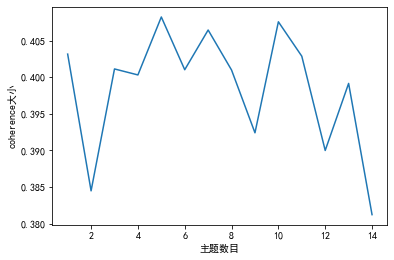

In [16]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
x = range(1,15)
# z = [perplexity(i) for i in x]  #如果想用困惑度就选这个
y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

In [ ]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes = 30,random_state=1)
topic_list=lda.print_topics()
print(topic_list)
 
for i in lda.get_document_topics(corpus)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
    print(i[bz][0])


In [1]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim.models import LdaModel
import pandas as pd
from gensim.corpora import Dictionary
from gensim import corpora, models
import csv

D:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('text_analysis_weibo.csv', index_col = 0)

In [3]:
df.head()

,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域
0,#高校通报教师图书馆打电话声音过大出言不逊#公道自在人心，谣言自在人心 ​​,0,0,0,a2331b38901d62d2d9a20529177ef3b3,0,22,湖北
1,转发C,0,0,0,d6dc4470f51fce93cc0cbad8abf55a75,0,33,广西
2,【#刘雨昕运动者联濛#河山覆冰雪，健儿迎冬奥[金牌]全能唱跳不设限，运动联濛开新年🇨🇳 期待...,0,0,0,372bc4782eb442b88035f920a7c1a68e,6,85,广东
3,丁程鑫//@丁程鑫后援会官博:#丁程鑫[超话]# ✨#丁程鑫 二十成金筑梦鑫世界# 大年初一...,0,0,0,6fe0d482bd3e78a3483e2a1d57f14ef2,75,1012,广东
4,诶，你们真不要脸诶。。。没资格宣传奥运。。。抵制抵制！,0,0,0,872380d71d6ee9130e8b49d331f2baa9,0,10,广东


### 语料预处理 

#### 剔除符号与数字

In [4]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['标题/微博内容'][0]
remove_nums(test)[:100]

'高校通报教师图书馆打电话声音过大出言不逊公道自在人心谣言自在人心'

In [5]:
# 加载中文停用词词典，可个性化设置
# stopwords = open('stopwords.txt', encoding = 'utf-8').read()

def clean_text(text):
    words = jieba.lcut(text)
    # words = [w for w in words if w not in stopwords and w!='[' and w!=']']
    return ' '.join(words)

test = df['标题/微博内容'][0]
clean_text(test)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\123\AppData\Local\Temp\jieba.cache
Loading model cost 0.970 seconds.
Prefix dict has been built successfully.


'# 高校 通报 教师 图书馆 打电话 声音 过大 出言不逊 # 公道 自 在 人心 ， 谣言 自 在 人心   \u200b \u200b'

In [7]:
df['标题/微博内容'] = df['标题/微博内容'].astype(str)
df['微博内容分词'] = df['标题/微博内容'].apply(remove_nums)
df['微博内容分词'] = df['微博内容分词'].apply(clean_text)
df['微博内容分词'] = df['微博内容分词'].apply(lambda x: x.split())
df.head()

,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域,微博内容分词
0,#高校通报教师图书馆打电话声音过大出言不逊#公道自在人心，谣言自在人心 ​​,0,0,0,a2331b38901d62d2d9a20529177ef3b3,0,22,湖北,"[高校, 通报, 教师, 图书馆, 打电话, 声音, 过大, 出言不逊, 公道, 自, 在,..."
1,转发C,0,0,0,d6dc4470f51fce93cc0cbad8abf55a75,0,33,广西,[转发]
2,【#刘雨昕运动者联濛#河山覆冰雪，健儿迎冬奥[金牌]全能唱跳不设限，运动联濛开新年🇨🇳 期待...,0,0,0,372bc4782eb442b88035f920a7c1a68e,6,85,广东,"[刘雨昕, 运动, 者, 联, 濛, 河山, 覆, 冰雪, 健儿, 迎, 冬奥, 金牌, 全..."
3,丁程鑫//@丁程鑫后援会官博:#丁程鑫[超话]# ✨#丁程鑫 二十成金筑梦鑫世界# 大年初一...,0,0,0,6fe0d482bd3e78a3483e2a1d57f14ef2,75,1012,广东,"[丁程鑫, 丁程鑫, 后援会, 官博丁, 程鑫, 超话, 丁程鑫, 二十, 成金筑梦鑫, 世..."
4,诶，你们真不要脸诶。。。没资格宣传奥运。。。抵制抵制！,0,0,0,872380d71d6ee9130e8b49d331f2baa9,0,10,广东,"[诶, 你们, 真, 不要脸, 诶, 没, 资格, 宣传, 奥运, 抵制, 抵制]"


### LDA主题分析

In [8]:
dictionary = corpora.Dictionary(df['微博内容分词'])     # 根据分词结果创建字典
corpus = [dictionary.doc2bow(text) for text in df['微博内容分词']]     # 根据分词结果创建语料库

In [17]:
# 训练LDA模型
lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)

In [18]:
# 查看主题
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.079*"的" + 0.024*"了" + 0.021*"是" + 0.015*"在" + 0.011*"也"')
(1, '0.041*"的" + 0.012*"在" + 0.009*"月" + 0.009*"年" + 0.008*"和"')
(2, '0.028*"的" + 0.014*"和" + 0.012*"发展" + 0.009*"建设" + 0.009*"等"')


In [19]:
df['微博内容分词'].iloc[0]

['高校',
 '通报',
 '教师',
 '图书馆',
 '打电话',
 '声音',
 '过大',
 '出言不逊',
 '公道',
 '自',
 '在',
 '人心',
 '谣言',
 '自',
 '在',
 '人心']

In [20]:
for index, score in sorted(lda_model[corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9560659527778625	 
Topic: 0.079*"的" + 0.024*"了" + 0.021*"是" + 0.015*"在" + 0.011*"也" + 0.008*"有" + 0.008*"都" + 0.007*"就" + 0.005*"这" + 0.005*"和"

Score: 0.023122573271393776	 
Topic: 0.028*"的" + 0.014*"和" + 0.012*"发展" + 0.009*"建设" + 0.009*"等" + 0.007*"在" + 0.005*"新" + 0.005*"为" + 0.005*"企业" + 0.005*"推进"

Score: 0.020811473950743675	 
Topic: 0.041*"的" + 0.012*"在" + 0.009*"月" + 0.009*"年" + 0.008*"和" + 0.008*"市场" + 0.007*"汽车" + 0.006*"为" + 0.006*"增长" + 0.006*"是"


In [21]:
documents = df['微博内容分词'].values

In [22]:
# Function to infer topics for a document
def infer_topics(lda_model, document):
    bow = dictionary.doc2bow(document)
    topics = lda_model.get_document_topics(bow)
    return topics

# Print topics for each document
for i, doc in enumerate(documents[:10]):
    doc_topics = infer_topics(lda_model, doc)
    print(f"Document {i+1}:")
    print(doc_topics)
    print()

Document 1:
[(0, 0.956082), (1, 0.02081144), (2, 0.02310656)]

Document 2:
[(0, 0.16667672), (1, 0.6666467), (2, 0.16667654)]

Document 3:
[(0, 0.8053742), (1, 0.18382354), (2, 0.010802281)]

Document 4:
[(0, 0.97336835), (1, 0.012950242), (2, 0.013681384)]

Document 5:
[(0, 0.94080085), (1, 0.028127303), (2, 0.031071872)]

Document 6:
[(0, 0.16667672), (1, 0.6666468), (2, 0.16667654)]

Document 7:
[(0, 0.8171877), (2, 0.1737075)]

Document 8:
[(0, 0.16667672), (1, 0.6666467), (2, 0.16667654)]

Document 9:
[(0, 0.8458104), (1, 0.13421859), (2, 0.019971019)]

Document 10:
[(0, 0.74893606), (1, 0.03630454), (2, 0.21475944)]



### 可视化

In [23]:
# 显示可视化界面
import pyLDAvis.gensim
lda_vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, n_jobs=1) #用pyLDAvis对LDA模型结果进行可视化
pyLDAvis.display(lda_vis)
